## Install Depencdencies

In [2]:
%%capture
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install plotly
%pip install sklearn
%pip install xgbtoost
%pip install statsmodels

## Import Libraries

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance

## Import Dataset

In [4]:
#Importing the data
data = pd.read_csv('../data/credit_risk_dataset.csv')

In [5]:
#Shape of the data
print('Shape of the dataset: ', data.shape)

#top 5 rows of the dataset
data.head()

Shape of the dataset:  (32581, 12)


person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

## Exploratory Data Analysis

In [6]:
#Describing the data
data.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

/var/folders/c7/k4qmw73x1ls_qrqgcrjtxb6m0000gn/T/ipykernel_52087/3627125592.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

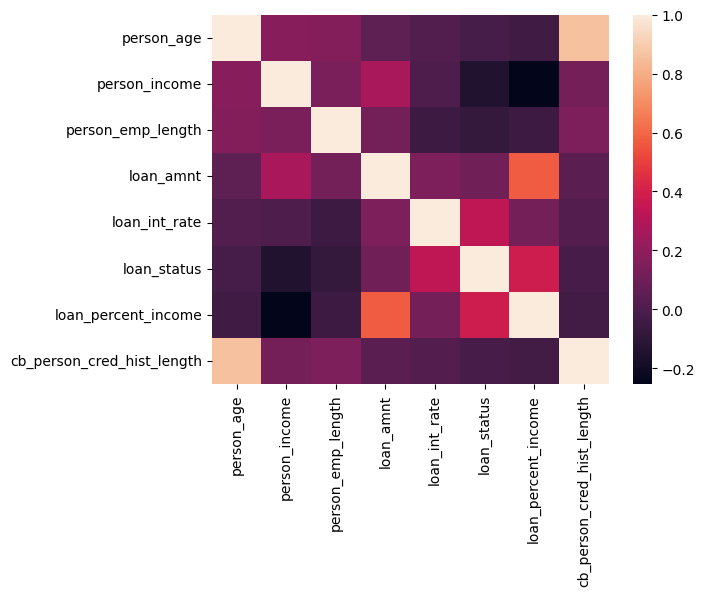

In [7]:
#Correlation heatmap
sns.heatmap(data.corr())

In [8]:
#Scatterplot matrix
fig = px.scatter_matrix(data, dimensions=['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate'], height=1000, width = 1000, color='loan_status', color_continuous_scale=px.colors.sequential.Purp_r)
fig.show()

In [9]:
#Box plot
fig = px.box(data, x="loan_grade", y="loan_percent_income", color="loan_status",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in data.columns},
category_orders={"loan_Grade":["A","B","C","D","E","F","G"]})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show()

In [10]:
# #Pairplot
sns.pairplot(data, hue='loan_status', height=2.5)

## Preprocessing

In [11]:
#checking for missing values
print(data.isna().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [12]:
#Remove missing values
data = data.dropna()
data.shape

(28638, 12)

In [13]:
#Checking for duplicates
print(data.duplicated().sum())

137


In [14]:
#Removing duplicates
data = data.drop_duplicates()
data.shape

(28501, 12)

In [15]:
#Removing outliers
data = data[data["person_age"]<=100]
data = data[data["person_emp_length"]<=100]
data = data[data["person_income"]<=400000]
data.shape

(28428, 12)

In [16]:
#One-hot encoding
data = pd.get_dummies(data, columns=['person_home_ownership', 'loan_intent'])

In [17]:
#Ordinal encoding
ordinal_map1 = {'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
data['loan_grade'] = data['loan_grade'].map(ordinal_map1)

ordinal_map2 = {'Y':1, 'N':0}
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(ordinal_map2)

In [18]:
data.head()

person_age  person_income  person_emp_length  loan_grade  loan_amnt  \
1          21           9600                5.0           6       1000   
2          25           9600                1.0           5       5500   
3          23          65500                4.0           5      35000   
4          24          54400                8.0           5      35000   
5          21           9900                2.0           7       2500   

   loan_int_rate  loan_status  loan_percent_income  cb_person_default_on_file  \
1          11.14            0                 0.10                          0   
2          12.87            1                 0.57                          0   
3          15.23            1                 0.53                          0   
4          14.27            1                 0.55                          1   
5           7.14            1                 0.25                          0   

   cb_person_cred_hist_length  person_home_ownership_MORTGAGE  \
1                           2                               0   
2                           3                               1   
3                           2                               0   
4                           4                               0   
5                           2                               0   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
1                            0                          1   
2                            0                          0   
3                            0                          0   
4                            0                          0   
5                            0                          1   

   person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
1                           0                              0   
2                           0                              0   
3                           1                              0   
4                           1                              0   
5                           0                              0   

   loan_intent_EDUCATION  loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  \
1                      1                            0                    0   
2                      0                            0                    1   
3                      0                            0                    1   
4                      0                            0                    1   
5                      0                            0                    0   

   loan_intent_PERSONAL  loan_intent_VENTURE  
1                     0                    0  
2                     0                    0  
3                     0                    0  
4                     0                    0  
5                     0                    1

In [19]:
#Percentage of non-default cases
data_0 = data[data.loan_status == 0].loan_status.count() / data.loan_status.count() * 100
data_0

78.25735190657099

In [20]:
data[data.loan_status == 0].loan_amnt.count()

22247

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('loan_status', axis=1), data['loan_status'], test_size=0.2)

## Model Training

There are several models that can be used for binary classification with multiple variables. Some popular options include:

1. Logistic Regression: Logistic regression is a linear model that is commonly used for binary classification problems. It models the relationship between the independent variables and the binary dependent variable as a logistic function.
2. Decision Trees: Decision trees are a type of non-linear model that can handle multiple variables and complex relationships between variables. They work by recursively splitting the data into smaller subsets based on the values of the independent variables.
3. Random Forest: Random forest is an extension of decision trees that combines multiple trees to form a single prediction. Random forest models are highly flexible and can handle a wide range of variable interactions and non-linear relationships.
4. Support Vector Machines (SVMs): SVMs are a type of linear model that can be used for binary classification problems. They work by finding the hyperplane that best separates the two classes in the feature space.
5. Gradient Boosting: Gradient Boosting is an ensemble learning method that trains multiple weak models, such as decision trees, and combines their predictions to form a single strong prediction.

Each of these models has its own strengths and weaknesses, and the best model for your specific problem will depend on the nature of the data, the complexity of the relationships between the variables, and other factors. In general, logistic regression and decision trees are good models to start with, while random forests, SVMs, and gradient boosting may be more appropriate for more complex problems.

In [22]:
# Model assessment function
def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)
    print('                   ', name, '\n',
    classification_report(y_test, model.predict(X_test)))

In [23]:
# Variables for testing
labels = [ 'DEFAULT', 'NO DEFAULT' ]
expected_y = y_test

In [24]:
# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the model's accuracy
lr_acc = accuracy_score(y_test, y_pred)
print("Logistic Regression's Accuracy:", lr_acc)

df_lr = pd.DataFrame(metrics.confusion_matrix(expected_y, y_pred), index=labels, columns=labels)

Logistic Regression's Accuracy: 0.8077734787196623


In [25]:
# Train the random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model's accuracy
rf_acc = accuracy_score(y_test, y_pred)
print("Random Forest's Accuracy:", rf_acc)

df_rf = pd.DataFrame(metrics.confusion_matrix(expected_y, y_pred), index=labels, columns=labels)

Random Forest's Accuracy: 0.9319380935631375


In [26]:
xgbt = xgb.XGBClassifier()
xgbt.fit(X_train, y_train)
print(); print(xgbt)

expected_y  = y_test
predicted_y = xgbt.predict(X_test)

xgbt_acc = accuracy_score(expected_y, predicted_y)
print("xgbtoosting's Accuracy:", xgbt_acc)

df_xgbt = pd.DataFrame(metrics.confusion_matrix(expected_y, y_pred), index=labels, columns=labels)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
xgbtoosting's Accuracy: 0.936334857544847


## Model Evaluation

In [27]:
# Logistic Regression
model_assess(lr, 'Logistic Regression')

# Random Forest Classifier
model_assess(rf, 'Random Forest')

# xgbtoosting
print('                   xgboosting\n', metrics.classification_report(expected_y, predicted_y))

                    Logistic Regression 
               precision    recall  f1-score   support

           0       0.81      0.98      0.89      4460
           1       0.74      0.17      0.27      1226

    accuracy                           0.81      5686
   macro avg       0.77      0.58      0.58      5686
weighted avg       0.80      0.81      0.76      5686

                    Random Forest 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4460
           1       0.97      0.71      0.82      1226

    accuracy                           0.93      5686
   macro avg       0.95      0.85      0.89      5686
weighted avg       0.94      0.93      0.93      5686

                   xgboosting
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4460
           1       0.96      0.74      0.83      1226

    accuracy                           0.94      5686
   macro avg       

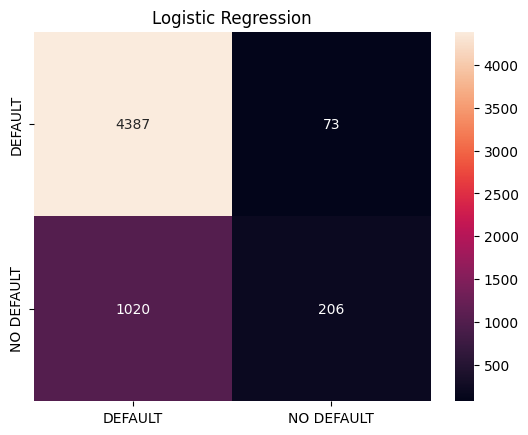

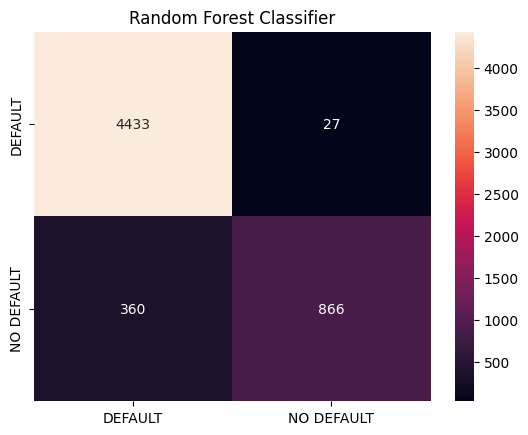

Text(0.5, 1.0, 'xgbtoosting')

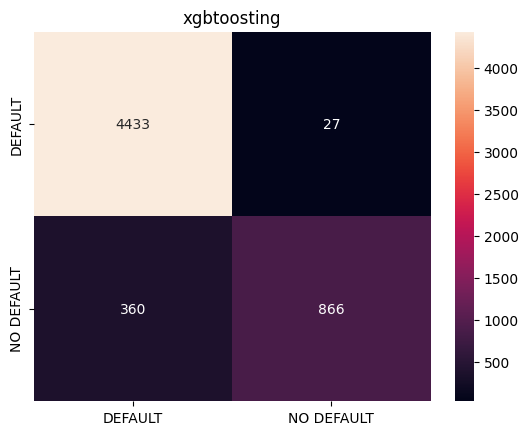

In [28]:
# Logistic Regression
sns.heatmap(df_lr, annot=True, fmt='g')
plt.title('Logistic Regression')

plt.show()

# Random Forest Classifier
sns.heatmap(df_rf, annot=True, fmt='g')
plt.title('Random Forest Classifier')

plt.show()

# xgbtoosting
sns.heatmap(df_xgbt, annot=True, fmt='g')
plt.title('xgbtoosting')

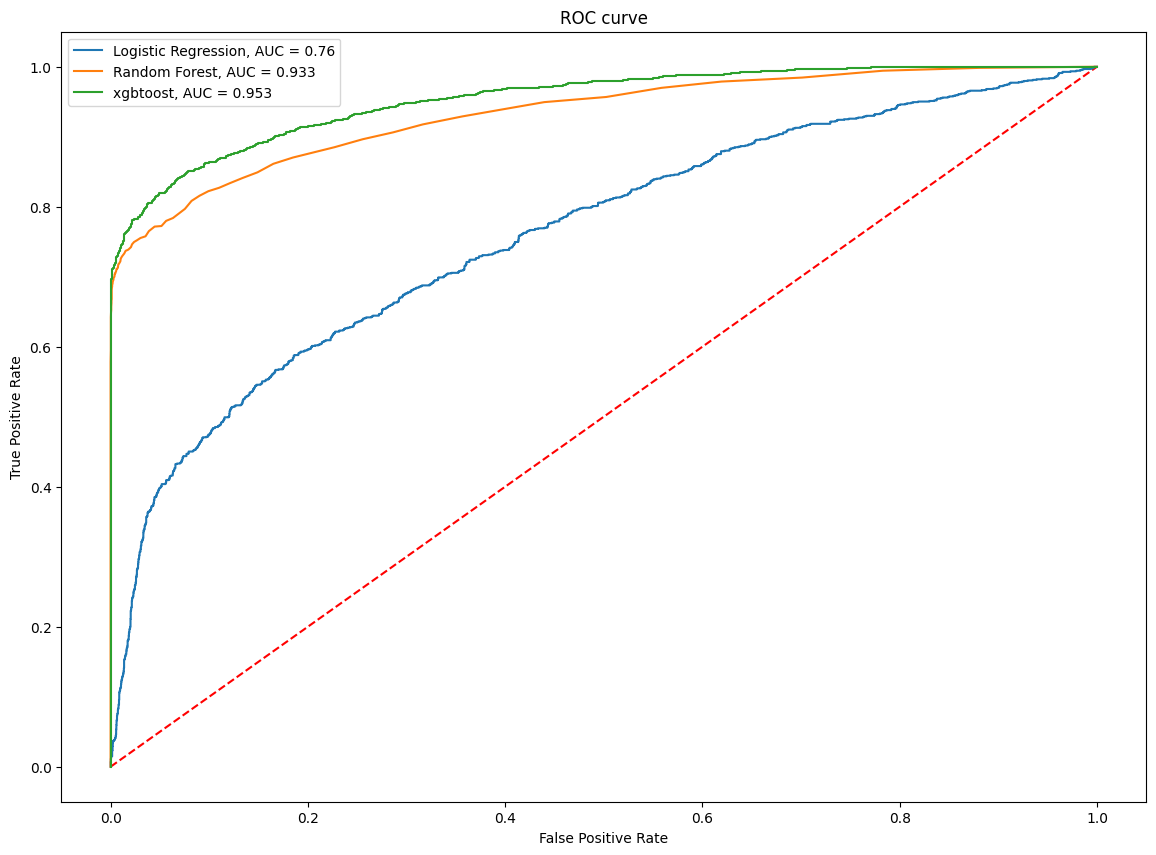

In [29]:
#ROC AUC
fig = plt.figure(figsize=(14,10))
plt.plot([0, 1], [0, 1],'r--')
#Logistic Regression
preds_proba_lr = lr.predict_proba(X_test)
probslr = preds_proba_lr[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probslr)
auclr = roc_auc_score(y_test, probslr)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auclr,3))}')
#Random Forest
preds_proba_rf = rf.predict_proba(X_test)
probsrf = preds_proba_rf[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsrf)
aucrf = roc_auc_score(y_test, probsrf)
plt.plot(fpr, tpr, label=f'Random Forest, AUC = {str(round(aucrf,3))}')
#xgboost
preds_proba_xgbt = xgbt.predict_proba(X_test)
probsxgbt = preds_proba_xgbt[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, probsxgbt)
aucxgbt = roc_auc_score(y_test, probsxgbt)
plt.plot(fpr, tpr, label=f'xgbtoost, AUC = {str(round(aucxgbt,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

/Users/hritikvalluvar/Projects/Credit Risk Analysis/venv/lib/python3.9/site-packages/sklearn/calibration.py:1000: FutureWarning:

The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).

/Users/hritikvalluvar/Projects/Credit Risk Analysis/venv/lib/python3.9/site-packages/sklearn/calibration.py:1000: FutureWarning:

The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).

/Users/hritikvalluvar/Projects/Credit Risk Analysis/venv/lib/python3.9/site-packages/sklearn/calibration.py:

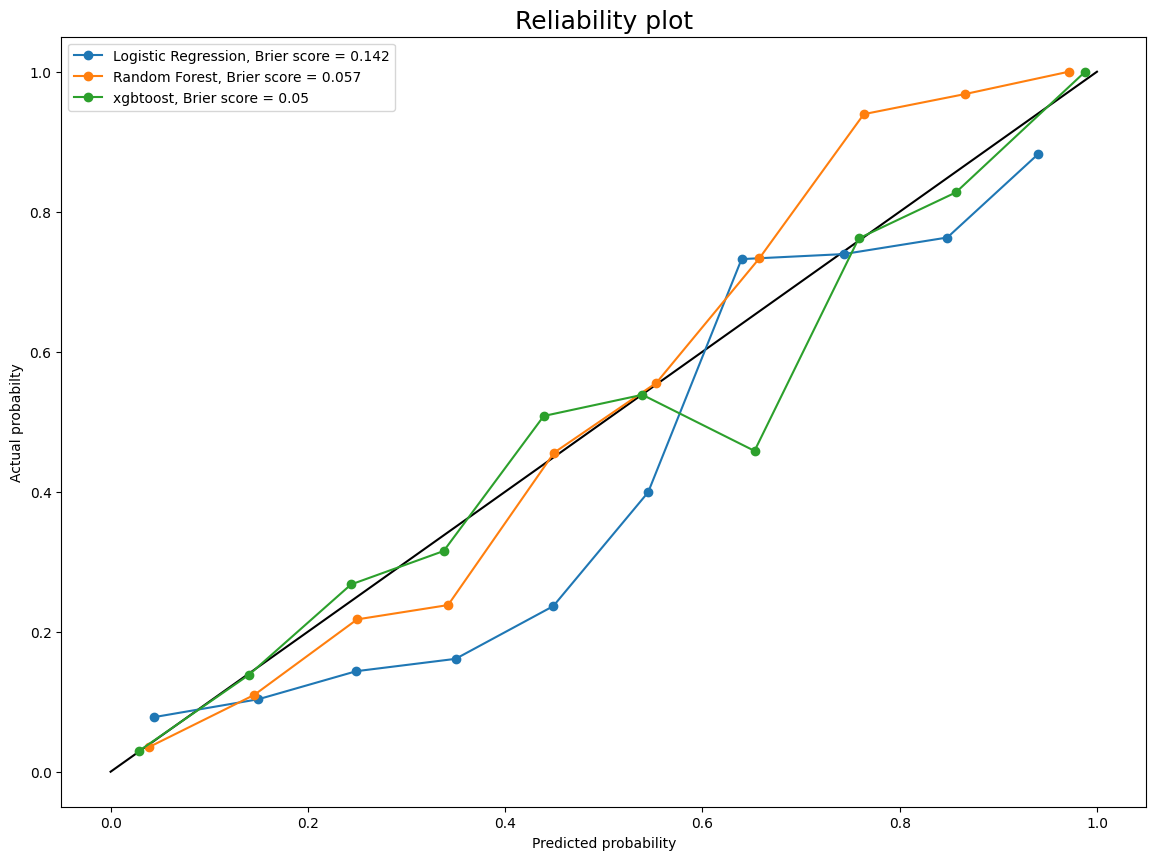

In [30]:
#Reliability plot and Brier Score
fig = plt.figure(figsize=(14,10))
plt.plot([0, 1], [0, 1], color="black")
#Logistic Regression
lr_y, lr_x = calibration_curve(y_test, preds_proba_lr[:,1], n_bins=10, normalize=True)
loss_lr = brier_score_loss(y_test, preds_proba_lr[:,1])
plt.plot(lr_x, lr_y, marker='o',label=f'Logistic Regression, Brier score = {str(round(loss_lr,3))}')
#Random Forest
rf_y, rf_x = calibration_curve(y_test, preds_proba_rf[:,1], n_bins=10, normalize=True)
loss_rf = brier_score_loss(y_test, preds_proba_rf[:,1])
plt.plot(rf_x, rf_y, marker='o', label=f'Random Forest, Brier score = {str(round(loss_rf,3))}')
#xgbtoost
preds_proba_xgbt = xgbt.predict_proba(X_test)
xgbt_y, xgbt_x = calibration_curve(y_test, preds_proba_xgbt[:,1], n_bins=10, normalize=True)
loss_xgbt = brier_score_loss(y_test, preds_proba_xgbt[:,1])
plt.plot(xgbt_x, xgbt_y, marker='o', label=f'xgbtoost, Brier score = {str(round(loss_xgbt,3))}')
plt.ylabel("Actual probabilty")
plt.xlabel("Predicted probability")
plt.title("Reliability plot")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

# Save Model

In [31]:
# Saving model
dump(xgbt, '../assets/model.pkl') 

['../assets/model.pkl']